In [1]:
import mo_descriptor as md
import nn_frame as nn
import numpy as np
import subprocess
subprocess.run('export TF_INTRA_OP_PARALLELISM_THREADS=12', shell=True)

2022-08-26 09:03:04.402196: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-26 09:03:04.402322: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


CompletedProcess(args='export TF_INTRA_OP_PARALLELISM_THREADS=12', returncode=0)

In [2]:
'''
prepare data_set
1. make mo_pair descriptor
'''
x_shift = np.arange(0, 4.1, 0.1)
y_shift = np.arange(0, 4.1, 0.1)
z_shift = np.zeros(x_shift.shape)
# the original mo, e.g. homo
homo = md.MO_descriptor('data/homo-s0.cube').make()
lumo = md.MO_descriptor('data/lumo-s0.cube').make()

# for the original pair of one mo and itself
homo_pair = md.MO_pair_descriptor(homo, homo).make()
lumo_pair = md.MO_pair_descriptor(lumo, lumo).make()

homo_pairs = np.zeros((len(x_shift)*len(y_shift),) + homo_pair.shape)
lumo_pairs = np.zeros((len(x_shift)*len(y_shift),) + lumo_pair.shape)

homo_ = np.zeros(homo.shape)

for ii, i in enumerate(x_shift):
    for jj, j in enumerate(y_shift):
        idx = ii * len(y_shift) + jj
        homo_[:,0] = np.add(homo[:,0],0)
        homo_[:,1] = np.add(homo[:,1],i)
        homo_[:,2] = np.add(homo[:,2],j)
        homo_[:,3] = np.add(homo[:,3],0)
        
        homo_pair_ = md.MO_pair_descriptor(homo, homo_).make()
        homo_pairs[idx] = homo_pair_

        
# def dir_mat(mat):
#     mat_shape = mat.shape
#     mat_ = mat.flatten()
#     for ii, i in enumerate(mat_):
#         if i > 1e-6:
#             mat_[ii] = 1
#         elif (i < 1e-6) and (i > -1e-6):
#             mat_[ii] = -1
#         elif i < -1e-6:
#             mat_[ii] = -1
#     return mat_.reshape(mat_shape)

# direct = dir_mat(homo_pair)

# # for the shifted pair
# homo_pairs = np.zeros((len(x_shift)*len(y_shift),) + homo_pair.shape)
# lumo_pairs = np.zeros((len(x_shift)*len(y_shift),) + lumo_pair.shape)
# for ii, i in enumerate(x_shift):
#     for jj, j in enumerate(y_shift):
#         idx = ii * len(y_shift) + jj
#         homo_pairs[idx][0] = homo_pair[0]
#         homo_pairs[idx][1] = np.add(homo_pair[1],i*direct[1])
#         homo_pairs[idx][2] = np.add(homo_pair[2],j*direct[2])
#         homo_pairs[idx][3] = homo_pair[3]
#         lumo_pairs[idx][0] = lumo_pair[0]
#         lumo_pairs[idx][1] = np.add(lumo_pair[1],i)
#         lumo_pairs[idx][2] = np.add(lumo_pair[2],j)
#         lumo_pairs[idx][3] = lumo_pair[3]
# np.save('homo_homo_pair.npy', homo_pairs)
# np.save('lumo_lumo_pair.npy', lumo_pairs)
# homo_pairs = np.load('homo_homo_pair.npy')
# lumo_pairs = np.load('lumo_lumo_pair.npy')

1 start clustering
2 start getting center


/home/dgg95223/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


1 start clustering
2 start getting center


/home/dgg95223/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [3]:
print(homo_pairs[:,1,:,:][81])

[[-0.1      -0.1      -7.167328 -7.167328 -0.1      -0.1      -7.167328
  -7.167328]
 [-0.1      -0.1      -7.167328 -7.167328 -0.1      -0.1      -7.167328
  -7.167328]
 [ 6.967328  6.967328 -0.1      -0.1       6.967328  6.967328 -0.1
  -0.1     ]
 [ 6.967328  6.967328 -0.1      -0.1       6.967328  6.967328 -0.1
  -0.1     ]
 [-0.1      -0.1      -7.167328 -7.167328 -0.1      -0.1      -7.167328
  -7.167328]
 [-0.1      -0.1      -7.167328 -7.167328 -0.1      -0.1      -7.167328
  -7.167328]
 [ 6.967328  6.967328 -0.1      -0.1       6.967328  6.967328 -0.1
  -0.1     ]
 [ 6.967328  6.967328 -0.1      -0.1       6.967328  6.967328 -0.1
  -0.1     ]]


In [4]:
'''
2. read coupling
'''
raw_data = np.loadtxt('data/cdft-V1V2.dat')
c_homo = np.add(raw_data[:,2], raw_data[:,3]) * 1/2
c_lumo = np.add(raw_data[:,4], raw_data[:,5]) * 1/2

In [5]:
# x1 = homo_pairs[:,0,:,:]
# x2 = homo_pairs[:,1,:,:]
# x3 = homo_pairs[:,2,:,:]
# x4 = homo_pairs[:,3,:,:]
# x = np.einsum('aij,aij,aij,aij->aij', x1, x2, x3, x4)

train_homo_pairs = homo_pairs
train_lumo_pairs = lumo_pairs[0:1200]

train_c_homo = c_homo
train_c_lumo = c_lumo[0:1200]

test_homo_pairs = homo_pairs[1200:]
test_lumo_pairs = lumo_pairs[1200:]

test_c_homo = c_homo[1200:].reshape((len(c_homo[1200:]),1))
test_c_lumo = c_lumo[1200:]

In [6]:
setting = {'activation':'tanh', 'nn_shape':(256,256,256), 'batch_size':41, 'training_steps':500000,\
'learning_rate': 0.0005, 'decay_rate':0.99, 'decay_per_steps':41, 'save_step':41, 'drop_rate':0, 'save_path':'./save2/model',\
'seed':None, 'debug_traj': True}
NN = nn.NN(setting_dict=setting)
NN.train(train_homo_pairs,train_c_homo)

training step:     0, loss:  2.492963075638


2022-08-26 09:03:27.879459: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-26 09:03:27.879580: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Deng-PC): /proc/driver/nvidia/version does not exist
2022-08-26 09:03:27.880044: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


training step:    41, loss:  1.396472334862
training step:    82, loss:  0.697279512882
training step:   123, loss:  0.541781008244
training step:   164, loss:  0.173969164491
training step:   205, loss:  0.153603047132
training step:   246, loss:  0.550437569618
training step:   287, loss:  0.159436628222
training step:   328, loss:  0.108560398221
training step:   369, loss:  0.070697344840
training step:   410, loss:  0.025775521994
training step:   451, loss:  0.038534946740
training step:   492, loss:  0.010736959055
training step:   533, loss:  0.023971691728
training step:   574, loss:  0.037656389177
training step:   615, loss:  0.028809087351
training step:   656, loss:  0.014072754420
training step:   697, loss:  0.007926405407
training step:   738, loss:  0.013543140143
training step:   779, loss:  0.030931644142
training step:   820, loss:  0.019215432927
training step:   861, loss:  0.008409325965
training step:   902, loss:  0.021738750860
training step:   943, loss:  0.0

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2.6774685


Text(0.5, 1.0, 'pred')

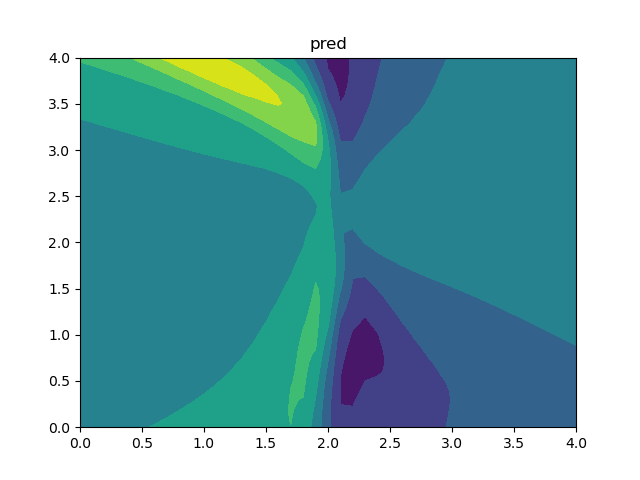

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget

print(np.mean((NN.model(train_homo_pairs, training=False)-c_homo)/c_homo))
x = np.linspace(0, 4, 41)
y = np.linspace(0, 4, 41)
X, Y = np.meshgrid(x, y)
Z = NN.model(train_homo_pairs, training=False).numpy().reshape((41,41))
Z1 = c_homo.reshape((41,41))

fix, ax = plt.subplots()
ax.contourf(x,y, Z)
ax.set_title('pred')

In [8]:
NN.model.summary()

Model: "mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           multiple                  0         
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 flatten_2 (Flatten)         multiple                  0         
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 concatenate (Concatenate)   multiple                  0         
                                                                 
 batch_normalization (BatchN  multiple                 1024      
 ormalization)                                                   
                                                               

In [9]:
print(homo[:,2])

[ 6.404766 11.926116  6.404766 11.926116  6.404766 11.926116  6.404766
 11.926116]
